In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(1) #sockets
tf.config.threading.set_intra_op_parallelism_threads(4) #procesadores
tf.config.set_soft_device_placement(True)

In [3]:
dt = tf.float32

In [4]:
def make_variables(x, y, initializer):
    return tf.Variable(initializer(shape=[x, y], dtype=dt))

In [5]:
def hardlim(x):
    return tf.constant([[0]], dtype=dt) if tf.less(x, 0) else tf.constant([[1]], dtype=dt)

In [6]:
init = tf.random_uniform_initializer(minval=-1., maxval=1.)

In [7]:
Patterns = tf.Variable(tf.zeros((8, 90000, 1), dtype=dt))

In [8]:
for i in range(1, 9):
    PATH = "LEGO_PERCEPTRON/"
    file = "P" + str(i) + ".jpg"
    image = cv.imread(PATH+file) 
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    gray_float = gray.astype(np.float32)
    gray_norm = gray_float/255
    gray_reshape = cv.resize(gray_norm, (1, 90000))
    Patterns[i-1, :].assign(gray_reshape)

In [9]:
Ti = tf.one_hot([0, 1], depth=2)
T = tf.concat([Ti, Ti, Ti, Ti], axis=1)
T

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1.]], dtype=float32)>

In [10]:
num_patterns = 8
num_inputs = 90000
num_neurons = 2
#T = tf.constant([0, 1, 0, 1, 0, 1, 0, 1], dtype=dt)
W = make_variables(num_neurons, num_inputs, init)
db = tf.Variable(tf.zeros([num_neurons, 1] ), dtype=dt)
b = make_variables(num_neurons, 1, init)
db_ant = make_variables(num_neurons, 1, init)
dw = tf.Variable(tf.zeros([num_neurons, num_inputs], dtype=dt))
dw_ant = tf.Variable(tf.zeros([num_neurons, num_inputs], dtype=dt))
e = tf.Variable(num_neurons, dtype=dt)
sum_e = tf.Variable(num_neurons, dtype=dt)

In [11]:
momentum = tf.constant(0.3, dtype=dt)
momentum_sub = tf.subtract(1, momentum)
learning_rate = tf.constant(0.00002, dtype=dt)

In [29]:
error = []
for epocas in range(1, 1000):
    dw = tf.Variable(tf.zeros([num_neurons, num_inputs], dtype=dt))
    sum_e = tf.Variable(tf.zeros([num_neurons, 1]), dtype=dt)
    for i in range(0, 8):
        #a = tf.map_fn(hardlim, tf.subtract(tf.matmul(W, Patterns[i, :]), b))
        a =  tf.subtract(tf.matmul(W, Patterns[i, :]), b)
        T_i = tf.reshape(T[:, i], shape=(num_neurons, 1))
        e = tf.subtract(T_i, a)
        sum_e = tf.add(sum_e, e)
        dw = tf.add(dw, e*tf.transpose(Patterns[i, :]))
        db = tf.add(db, sum_e)
    dw_ant = tf.add(tf.multiply(dw_ant, momentum), tf.multiply(dw, momentum_sub))
    db_ant = tf.add(tf.multiply(db_ant, momentum), tf.multiply(db, momentum_sub))
    W = tf.add(W, tf.multiply(dw_ant, learning_rate))
    b = tf.subtract(b, tf.multiply(db_ant, learning_rate))
    error.append(sum_e.numpy()[0, 0])

In [30]:
sum_e.numpy()[0, 0]

0.3008728

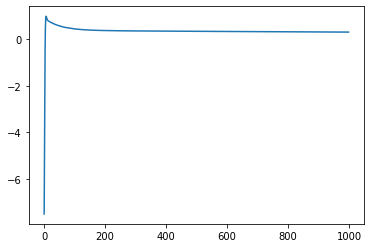

In [31]:
plt.plot(error)

In [32]:
a.numpy()[:, 0]

array([0.06088257, 0.96193695], dtype=float32)

In [33]:
estimated = []
for i in range(0, 8):
    a = tf.subtract(tf.matmul(W, Patterns[i, :]), b)
    estimated.append(a.numpy()[:, 0])  
estimated, b

([array([0.63819885, 0.22458649], dtype=float32),
  array([0.06097412, 0.96190643], dtype=float32),
  array([ 18.654312, -14.239311], dtype=float32),
  array([2.2519073, 0.7290573], dtype=float32),
  array([ 30.250687, -21.356453], dtype=float32),
  array([-9.152222,  5.079956], dtype=float32),
  array([ 33.140457, -21.365135], dtype=float32),
  array([-10.837906,   7.303955], dtype=float32)],
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 170.66743],
        [-107.2232 ]], dtype=float32)>)

In [230]:
img_o = tf.reshape(W, (2, 300,300))

In [231]:
img1 = img_o[0, :, :].numpy()
img2 = img_o[1, :, :].numpy()

In [221]:
for i, row in enumerate(img1):
    for j, col in enumerate(row):
        if img1[i][j] <= 0:
            img1[i][j] = 0
for i, row in enumerate(img2):
    for j, col in enumerate(row):
        if img2[i][j] <= 0:
            img2[i][j] = 0
        else:
            img2[i][j] = -img2[i][j]

In [234]:
mag1 = img1.max()-img1.min()
mag2 = img2.max()-img2.min()

In [235]:
img1_res = ((img1 - img1.min()) / mag1) * 255
img2_res = ((img2 - img2.min()) / mag2) * 255

In [236]:
img1_np = np.array(img1_res, dtype="uint8")
img2_np = np.array(img2_res, dtype="uint8")

In [237]:
cv.imshow("window", img1_np)
cv.waitKey(2000)

cv.imshow("window", img2_np)
cv.waitKey(2000)

cv.destroyAllWindows()

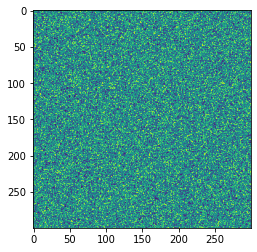

In [238]:
plt.imshow(img1_np)

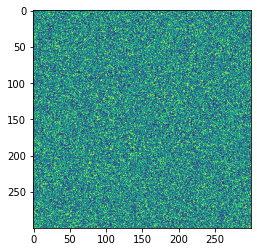

In [239]:
plt.imshow(img2_np)